# Classification of quantum states with high dimensional entanglement 

## Circuits and computations
Version compatible with 1st and 2d pilot studies

In [1]:
import numpy as np
import copy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.tools.visualization import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import json
from scipy.signal import savgol_filter
import time
from qiskit.tools.monitor import job_monitor

In [2]:
from o_plot import opl # utilities for result plot
from c_utils import new_cut # circuit building utilities

In [3]:
def json_dic_loader(dic_name):
    f = open(data_directory+dic_name+'.json')
    return json.load(f)

In [4]:
# common code for calling the classifier for ideal device and for real devices
def add_single_dic(target_data_list, optimizer_type='old'):
    start_time = time.time()                
           
    print("started",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name)
    
    # added for D,S,M choice. Mainstream : mixed set of 20 states
    first = 0
    last = nb_states
    if unique_char == "D":
        last = int(nb_states/2)
    elif unique_char == "S":
        first = int(nb_states/2)
    
    if optimizer_type=='old':
        from o_utils.ora import provide_error_curve as provide_error_curve 
    elif optimizer_type=='new':
        from o_utils.ora import provide_error_curve_new as provide_error_curve
    else:
        raise ValueErrror('define a proper optimizer type!')
        
    
    # get the classifier error curve in function of the number of shot and the "safe shot number" 
    error_curve, safe_rate, ernb = provide_error_curve(PD_model=model_dic[model_name][first:last,:],
                                                   PD_test=PD_test[first:last,:],
                                                   trials=trials,
                                                   window=window,
                                                   epsilon=epsilon,
                                                   max_shots=max_shots,
                                                   pol=pol,
                                                   verbosality=verbosality)


    tail = savgol_filter(ernb, window, pol, axis=0)
    len_curve = len(error_curve)
    safe_shot_nb = len_curve - int((window-1)/2) # OK
    print('safe_shot_nb',safe_shot_nb, 'safe_rate',safe_rate, "nb trials:",trials)
    err_rates = tail[int((window-1)/2),:]/trials 
    err_rate_max = np.max(err_rates)
    err_rate_min = np.min(err_rates)
    r=4
    print("savgol interpolated error rate mean:", np.round(np.mean(err_rates),r),
          "min:", np.round(err_rate_min,r),
          "max:", np.round(err_rate_max,r), "for",
          [ien for ien, jen in enumerate(err_rates) if jen == err_rate_max])
    end_time = time.time()
    
    #save the data in a list of dictionaries :
    single_dic={"project":mitig_name,
                "id_gates":id_gates,
                "mitigation":mit_str,
                "model":model_name,
                "metric":o_metric, "device":project_device,                              
                "curve_length":len_curve, 
                "shots": safe_shot_nb,
                "shots_rate": safe_rate,                                                                                    
                "error_curve":error_curve,
                "trials":trials,"window":window,
                "epsilon":epsilon,"SG_pol": pol,                         
                "computation_time":end_time-start_time,
                "time_completed":time.strftime('%d/%m/%Y %H:%M:%S'),
                "trials":trials,
                "QV": QV_dic[project_device],
                "fidelity": fidelity_dic[project_device],
                "error_nb":ernb}
    target_data_list.append(single_dic)
    
    print("completed",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name,"\n")

## Set up the simulator and layout for 5 qubits

In [5]:
simulator = Aer.get_backend('qasm_simulator')

In [6]:
#specify the layout of the devices
used_qubits = 5
qubit_list = [0,1,2,3,4]

In [7]:
#short_version = False
#program_name="QAD" # 1st pilot project GHZ Psi+ / W Phi+
program_name="AL2" # 2d pilot project W Psi+ / Wbar Phi+
Flag_char = "DS" # this for a mix of two types of separable states
if len(Flag_char) >= 2:
    unique_char = "M"
else:
    unique_char = Flag_char

In [8]:
# These dictionaries for the devices used in the study
if program_name == "QAD":
    fidelity_dic = {'ibmq_athens': 0.925110, 'ibmq_valencia': 0.809101, 'ibmq_ourense': 0.802380,
                "ibmqx2": 0.627392, 'ibmq_santiago': 0.919399, 'ibmq_vigo': 0.908840, 'ideal_device': 1.0}
    data_directory = "data_files/"
elif program_name == "AL2":
    fidelity_dic = {'ibmq_athens': 0.910145, 'ibmq_valencia': 0.794262, 'ibmq_ourense': 0.818974,
                "ibmqx2": 0.359528, 'ibmq_santiago': 0.900024, 'ibmq_vigo': 0.841831, 'ideal_device': 1.0}
    data_directory = "data2_files/"
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0, 
          "ibmqx2": 8.0, 'ibmq_santiago': 32.0, 'ibmq_vigo': 16.0, 'ideal_device': np.inf}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor',  'ideal_device': "Ide"}

In [9]:
# specify the device: here first the ideal noise-free device
project_device = 'ideal_device'
device_name = dev_dic[project_device]

In [10]:
# specify the nb of id gates between state creation and measurements
# zero for the ideal device
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))

In [11]:
# tail of the file names for RAM storage
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

AL2_Ide
AL2_Ide_M000


In [12]:
# establish the result label list
# meas_calibs will be used for mitigation in the real device section
qr = QuantumRegister(used_qubits) 
meas_calibs, label_list = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
nb_labels=len(label_list)
print(nb_labels,label_list)

32 ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [13]:
len(meas_calibs)

32

In [14]:
# permutation list
# here it is simple to write down the list, 
# but a version using itertools will be wellcome for >5 qubits projects
if used_qubits == 5:
    q_perm = [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 1, 4, 2, 3], [0, 2, 3, 1, 4], [0, 2, 4, 1, 3],
          [0, 3, 4, 1, 2], [1, 2, 3, 0, 4], [1, 2, 4, 0, 3], [1, 3, 4, 0, 2], [2, 3, 4, 0, 1]]
else:
    print("work in progress - meanwhile please provide the list of permutations")

## Create the quantum states

In [15]:
# define the two subsets of 10 separable states
if program_name == "QAD":
    state_1a = ["W","Phi+"]
    state_1b = ["GHZ","Psi+"]
elif program_name == "ALT" or "AL2":
    state_1a = ["W","Psi+"]
    state_1b = ["Wbar","Phi+"]
l_states = state_1a+state_1b
l_states

['W', 'Psi+', 'Wbar', 'Phi+']

In [16]:
# version 20 circuits for demonstration
# (in the version run on real devices: two batches of 10 circuits, "shallow" and "deep")

# these circuits limited to state creation are ready to be saved 
# for  ultimately building circuits adapted to noisy simulator and real devices
# as option, these circuits will include a row of id gates between creation and measurements

circ_ori = []
for i_s in range(0,len(l_states),2):
    for perm in q_perm:
            mycircuit = QuantumCircuit(used_qubits, used_qubits)                                   
            mycircuit = new_cut.circuit_builder(mycircuit, perm, l_states[i_s],l_states[i_s+1])
            circ_ori.append(mycircuit)

In [17]:
# add measurement section to the circuit set newly created:
nb_states = len(circ_ori)
circ_ideal = copy.deepcopy(circ_ori)
for i_state in range(nb_states):
    new_cut.add_barrier_and_measure(circ_ideal[i_state],qubit_list)

In [18]:
ideal_dic = {}

## Obtain result distributions on  noise free simulator

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [19]:
# try loading the dictionary of results if its creation was skipped
if len(ideal_dic) == 0:
    ideal_dic = json_dic_loader("ideal_dic_"+project_name)

In [20]:
nb_states = len(ideal_dic)
nb_labels = len(list(ideal_dic.values())[0])
s_sim = sum(list(ideal_dic.values())[0].values())

In [21]:
def print_first_and_last_row(PDM):
    print("first and last rows of the probability distribution matrix of dimension "+str(nb_states)+"x"+str(nb_labels))
    print(np.round(PDM[0:1,:],4))
    print("   ...")
    print(np.round(PDM[-1:,:],4))

In [22]:
PD_ideal =  np.ndarray((nb_states,nb_labels))
for i_state in range(nb_states):
    PD_ideal[i_state, :] = list(ideal_dic[str(i_state)].values())
# now a little trick to get the ideal values from the simulator approximated values
with np.errstate(divide='ignore'): # ignore the divide by zero warning
    PD_ideal = 1/np.round(s_sim/(PD_ideal))
# have a look at the matrix head and tail:
print_first_and_last_row(PD_ideal)

first and last rows of the probability distribution matrix of dimension 20x32
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1667
  0.1667 0.     0.1667 0.     0.     0.     0.     0.1667 0.1667 0.
  0.1667 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    ]]
   ...
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.1667 0.     0.     0.1667 0.     0.     0.     0.
  0.1667 0.     0.     0.1667 0.1667 0.     0.     0.1667 0.     0.
  0.     0.    ]]


## Monte Carlo simulation for the ideal device

In [23]:
# here will be appended the data we want for the curve plot 
ideal_data_list=[]

###  Old optimizer

In [24]:
# you may want to skip this cell as it will require a long time
# because of the high number of trials required by the Monte Carlo simulation for each nb o shots value

# the following values are defined in the study summary (readme file):
trials=1000 # to be set to 10000 if not demo 
window=5 # shorter window than for the real device counts
epsilon = .001
min_shots = 5
max_shots = 100
pol=2

subset = None # variable not used here
verbosality = 5 # printing step for intermediate results when increasing the experiment shot number 

PD_test = PD_ideal
mitigation_dic =  {"Na": None} 
o_metrics_desired = ['jensenshannon', 'sqeuclidean']
model_dic = {"ideal_sim": PD_ideal}
for mit_str, mitigation in mitigation_dic.items():
    if mitigation != None: # thus only for counts on real device
        PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    for o_metric in o_metrics_desired:           
            for model_name in model_dic.keys():
                add_single_dic(ideal_data_list)                

started 30/05/2021 21:11:01 AL2_Ide mitigation Na jensenshannon ideal_sim
5 0.02955 [ 38  43  47  35  30  80  28  43  76 107  13   4   3   0   3   1   8   8
  13  11]
10 0.0024500000000000004 [ 4  6  5  2  3  7  1  0  6 13  0  0  0  0  0  0  1  0  1  0]
15 0.0005 [1 1 1 0 1 1 1 1 1 2 0 0 0 0 0 0 0 0 0 0]
20 5e-05 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
safe_shot_nb 18 safe_rate 0.0009428571428571425 nb trials: 1000
savgol interpolated error rate mean: 0.0001 min: -0.0002 max: 0.0009 for [1]
completed 30/05/2021 21:12:23 AL2_Ide mitigation Na jensenshannon ideal_sim 

started 30/05/2021 21:12:23 AL2_Ide mitigation Na sqeuclidean ideal_sim
5 0.02985 [ 46  51  52  28  34  73  34  35  69 116   7   4   1   1   1   2  10   8
  15  10]
10 0.00275 [ 5  3  3  3  4  5  4  2  7 14  0  0  0  0  2  1  0  1  1  0]
15 0.00075 [1 5 2 1 1 0 1 0 2 2 0 0 0 0 0 0 0 0 0 0]
safe_shot_nb 17 safe_rate 0.0009428571428571425 nb trials: 1000
savgol interpolated error rate mean: 0.0001 min: -0.0004 max: 0.0009 

<Figure size 432x288 with 0 Axes>

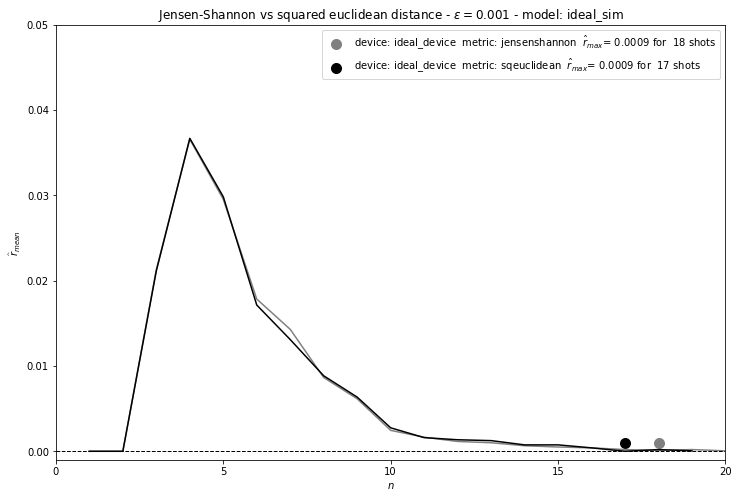

In [25]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors the unsmoothed values 
opl.plot_curves(ideal_data_list,np.array([0,1]),
            "Jensen-Shannon vs squared euclidean distance - $\epsilon=0.001$" , 
             ["model"], ["device","metric"],
             right_xlimit = 20, bottom_ylimit = -0.001, top_ylimit = 0.05)

## New optimizer

In [26]:
# here will be appended the data we want for the curve plot 
ideal_data_list=[]

# the following values are defined in the study summary (readme file):
trials=1000 # to be set to 10000 if not demo 
window=5 # shorter window than for the real device counts
epsilon = .001
min_shots = 5
max_shots = 100
pol=2

subset = None # variable not used here
verbosality = 5 # printing step for intermediate results when increasing the experiment shot number 

PD_test = PD_ideal
mitigation_dic =  {"Na": None} 
o_metrics_desired = ['jensenshannon', 'sqeuclidean']
model_dic = {"ideal_sim": PD_ideal}
for mit_str, mitigation in mitigation_dic.items():
    if mitigation != None: # thus only for counts on real device
        PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    for o_metric in o_metrics_desired:           
            for model_name in model_dic.keys():
                add_single_dic(ideal_data_list, optimizer_type='new')  

started 30/05/2021 21:13:39 AL2_Ide mitigation Na jensenshannon ideal_sim
safe_shot_nb 18 safe_rate 0.001 nb trials: 1000
savgol interpolated error rate mean: 0.0 min: 0.0 max: 0.0 for [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
completed 30/05/2021 21:14:21 AL2_Ide mitigation Na jensenshannon ideal_sim 

started 30/05/2021 21:14:21 AL2_Ide mitigation Na sqeuclidean ideal_sim
safe_shot_nb 18 safe_rate 0.001 nb trials: 1000
savgol interpolated error rate mean: 0.0 min: 0.0 max: 0.0 for [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
completed 30/05/2021 21:15:08 AL2_Ide mitigation Na sqeuclidean ideal_sim 



<Figure size 432x288 with 0 Axes>

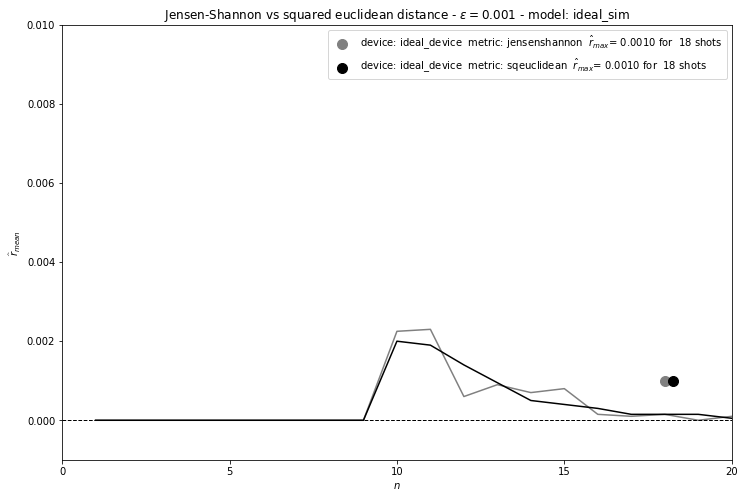

In [27]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors the unsmoothed values 
opl.plot_curves(ideal_data_list,np.array([0,1]),
            "Jensen-Shannon vs squared euclidean distance - $\epsilon=0.001$" , 
             ["model"], ["device","metric"],
             right_xlimit = 20, bottom_ylimit = -0.001, top_ylimit = 0.01)

# Real device section

In [28]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

/Users/ctuysuz/opt/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [29]:
project_device = 'ibmq_athens'# you may choice here a different backend
device_name = dev_dic[project_device]
mitig_name = program_name + "_" + device_name
print(mitig_name)

AL2_Ath


In [30]:
#determine here the backend
device = provider.get_backend(project_device) # the backend names are listed here above
properties = device.properties()
coupling_map = device.configuration().coupling_map

# obtain mitigation filter

In [31]:
# retrieve the corresponding measurement mitigation filter obtained at experimental time
# use a fake job because use of the from_dict method
simulator = Aer.get_backend('qasm_simulator')
fake_job_cal = execute(meas_calibs, backend=simulator, shots=1)
fake_cal_results = fake_job_cal.result()
cal_results_dic = json_dic_loader("cal_results_dic_"+mitig_name) 
if 'date' in cal_results_dic.keys():
    str(cal_results_dic['date'])
cal_results = fake_cal_results.from_dict(cal_results_dic)
meas_fitter = CompleteMeasFitter(cal_results, label_list, qubit_list=qubit_list, circlabel='mcal')
meas_filter = meas_fitter.filter
# have a look at the average measurement fidefily of this device:
print("Average Measurement Fidelity was: %f" % meas_fitter.readout_fidelity(), "for",project_device)

Average Measurement Fidelity was: 0.910145 for ibmq_athens


### Transpile the basic circuits for running on real device
In this demo, these are not the circuits which were actually run on real devices (not the same transpiler seed).
The optimization level is set to 2 instead of 3 in real experiments, for speed and also because at this moment there is a transpiler error occuring for ibmqx2: 'Maximum iteration reached. max_iteration=1000' 

In [32]:
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))
project_name = mitig_name + "_" + unique_char + zfilled
print(project_name)

AL2_Ath_M000


In [33]:
# transpile
verbose = True  
summary_dic = {}
seed_transpiler_list = list(range(nb_states))
real_circs = []
start_time = time.strftime('%d/%m/%Y %H:%M:%S')    
print("Start at DMY: ",start_time)
for i_state in list(range(nb_states)):    
    # prepare circuit to be transpiled
    circuit = copy.deepcopy(circ_ori[i_state])
    if id_gates > 0:
        circuit.barrier()
        for id_gates_index in range(id_gates):
            for index, value in enumerate(qubit_list):
                circuit.id(value)
    
    new_cut.add_barrier_and_measure(circuit, qubit_list)
    
    summary = []        
    depth_list = [] 

    Q_state_opt_new = transpile(circuit, backend=device,
                        coupling_map = coupling_map,
                        seed_transpiler=seed_transpiler_list[i_state],
                        optimization_level=2,
                        initial_layout=qubit_list)

    summary_dic[i_state] = {"depth": Q_state_opt_new.depth(),
                            'circuit':Q_state_opt_new}
    real_circs.append(Q_state_opt_new)
    if verbose:
        print("circuit %2i" % i_state,"length",summary_dic[i_state]["depth"],
              "DMY: ",time.strftime('%d/%m/%Y %H:%M:%S')) 

end_time = time.strftime('%d/%m/%Y %H:%M:%S')  
print("Completed at DMY: ",end_time)    

Start at DMY:  30/05/2021 21:15:29
circuit  0 length 24 DMY:  30/05/2021 21:15:29
circuit  1 length 26 DMY:  30/05/2021 21:15:29
circuit  2 length 34 DMY:  30/05/2021 21:15:30
circuit  3 length 30 DMY:  30/05/2021 21:15:30
circuit  4 length 33 DMY:  30/05/2021 21:15:30
circuit  5 length 28 DMY:  30/05/2021 21:15:30
circuit  6 length 33 DMY:  30/05/2021 21:15:30
circuit  7 length 31 DMY:  30/05/2021 21:15:30
circuit  8 length 25 DMY:  30/05/2021 21:15:30
circuit  9 length 23 DMY:  30/05/2021 21:15:31
circuit 10 length 28 DMY:  30/05/2021 21:15:31
circuit 11 length 23 DMY:  30/05/2021 21:15:31
circuit 12 length 29 DMY:  30/05/2021 21:15:31
circuit 13 length 34 DMY:  30/05/2021 21:15:31
circuit 14 length 36 DMY:  30/05/2021 21:15:31
circuit 15 length 30 DMY:  30/05/2021 21:15:31
circuit 16 length 36 DMY:  30/05/2021 21:15:32
circuit 17 length 38 DMY:  30/05/2021 21:15:32
circuit 18 length 28 DMY:  30/05/2021 21:15:32
circuit 19 length 26 DMY:  30/05/2021 21:15:32
Completed at DMY:  30/05/

# run job

### Load  the transpiled circuits that were actually run 


In [34]:
#changing keys of dictionary for merging:    
def key_change(ini_dict, i_subset):
    ini_list = []
    len_ini = len(ini_dict)
    for i in range(len_ini):
        ini_list.append(str(i+i_subset*len_ini))
    return dict(zip(ini_list, list(ini_dict.values()))) 

In [35]:
if program_name == "QAD":
    #retrieve the data corresponding to the 1st project
    lfc = list(Flag_char)
    circ_ideal =[]
    empirical_dic = {}

    for i_subset, subset in enumerate(lfc):
        qasm_circs_dic = json_dic_loader('qasm_circs_dic_QAD_'+device_name+'_'+ subset + zfilled)
        j=0 # j included for project with several transpilation sessions for each device - not used here
        qasm_circs = qasm_circs_dic[str(j)]
        nb_circs = len(qasm_circs)        
        for i_circs in range(nb_circs):
            circ_ideal.append(QuantumCircuit().from_qasm_str(qasm_circs[i_circs]))
        empirical_dic = {**empirical_dic,
                     **key_change(json_dic_loader("experimental"+"_"+mitig_name +"_"\
                                  +subset+zfilled), i_subset)}
    test_dic = copy.deepcopy(empirical_dic)
    #nb_states = len(circ_ideal)

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [36]:
if program_name == "AL2":
    empirical_dic = json_dic_loader('experimental_'+project_name) 
    test_dic = json_dic_loader('test_'+project_name) 

In [37]:
def rectify_counts(tot_res, test_cqi,mitigation,m_filter) :       
        
        void_counts = dict(zip(label_list, np.zeros(2**used_qubits)))
        try:
            counts_results_real_test = tot_res[str(test_cqi)]
        except KeyError as error:            
            counts_results_real_test = tot_res[test_cqi]

        raw_counts_test = copy.deepcopy(void_counts)
        raw_counts_test.update(counts_results_real_test)

        if mitigation:
            mitigated_results_test = meas_filter.apply(raw_counts_test, method = 'least_squares')
            returned_counts = copy.deepcopy(void_counts)
            returned_counts.update(mitigated_results_test)
                        
        else:
            returned_counts = copy.deepcopy(raw_counts_test)
            
        return returned_counts

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [38]:
def get_clean_matrix(dic, mitigation,m_filter):
    clean_matrix =  np.ndarray((nb_states,nb_labels)) 
    for i_state in range(nb_states):
        rectified_counts = rectify_counts(dic,i_state, mitigation,m_filter) # get a rectified counts dictionary       
        clean_matrix[i_state, :] = list(rectified_counts.values())
    clean_matrix = clean_matrix/clean_matrix.sum(axis=1, keepdims=True)
    return clean_matrix  

In [39]:
# We need to create a first matrix version. It will then vary for each considered set of distribution
mitigation = False
PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter) 
print_first_and_last_row(PD_exper)

first and last rows of the probability distribution matrix of dimension 20x32
[[0.0021 0.0095 0.0105 0.     0.0095 0.0004 0.0005 0.0004 0.0231 0.1349
  0.1444 0.0029 0.1351 0.0063 0.0078 0.0051 0.0234 0.1427 0.1523 0.0023
  0.1346 0.007  0.0089 0.0066 0.0016 0.0078 0.0084 0.0005 0.0098 0.0006
  0.0004 0.0005]]
   ...
[[9.400e-03 5.000e-04 4.000e-04 1.170e-02 1.030e-02 2.000e-04 1.000e-04
  9.500e-03 1.430e-02 5.000e-04 9.000e-04 1.390e-02 1.437e-01 4.900e-03
  5.000e-03 1.440e-01 1.610e-02 7.000e-04 2.000e-04 1.820e-02 1.135e-01
  3.500e-03 3.800e-03 1.207e-01 1.472e-01 6.800e-03 5.700e-03 1.508e-01
  2.150e-02 1.100e-03 5.000e-04 2.030e-02]]


In [40]:
if program_name == "QAD":
    PD_test = copy.deepcopy(PD_exper)
elif program_name == "AL2":
    mitigation = False
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    print_first_and_last_row(PD_test)

first and last rows of the probability distribution matrix of dimension 20x32
[[2.300e-03 1.230e-02 1.160e-02 1.000e-04 1.260e-02 4.000e-04 1.300e-03
  4.000e-04 2.510e-02 1.302e-01 1.464e-01 3.800e-03 1.298e-01 5.400e-03
  1.160e-02 6.300e-03 2.440e-02 1.421e-01 1.447e-01 2.600e-03 1.404e-01
  7.800e-03 1.100e-02 6.700e-03 1.100e-03 6.500e-03 7.200e-03 1.000e-04
  5.200e-03 2.000e-04 2.000e-04 1.000e-04]]
   ...
[[1.060e-02 1.000e-04 2.000e-04 9.900e-03 1.140e-02 1.000e-04 2.000e-04
  1.270e-02 1.570e-02 7.000e-04 5.000e-04 1.720e-02 1.534e-01 5.500e-03
  4.500e-03 1.460e-01 1.820e-02 6.000e-04 6.000e-04 1.680e-02 1.152e-01
  4.500e-03 3.300e-03 1.099e-01 1.494e-01 4.400e-03 3.800e-03 1.461e-01
  1.950e-02 5.000e-04 5.000e-04 1.770e-02]]


## Monte Carlo simulation for the real device

In [41]:
# here will be appended the data we want for the final plot of this notebook
empirical_data_list=[]

In [42]:
# the following values are defined in the study summary notebook:
trials=1000 # should be 1000 if not demo
window=11
epsilon = .001
max_shots = 500
pol=2

verbosality = 10 # printing step for intermediate results when increasing the experiment shot number 

# In this section you can easily make your choice of combinations:
# mitigation or not, metric, model 

mitigation_dic =  {"no":False, "yes" : True} 
#mitigation_dic =  {"no":False} 
#mitigation_dic =  {"yes" : True} 

o_metrics_desired = ['jensenshannon', 'sqeuclidean']
#o_metrics_desired = ['jensenshannon']
#o_metrics_desired = ['sqeuclidean']

model_dic = {"empirical": PD_exper, "ideal_sim": PD_ideal}
#model_dic = {"empirical": PD_exper}
#model_dic = {"ideal_sim": PD_ideal}

# Obtain a sequence of results in form of a list of dictionaries

for mit_str, mitigation in mitigation_dic.items():
    # here we toggle PD_exper as we toggled mitigation status
    PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    for o_metric in o_metrics_desired:
        print(project_name, model_dic.keys(), o_metric)        
        for model_name in model_dic.keys():
            add_single_dic(empirical_data_list)

AL2_Ath_M000 dict_keys(['empirical', 'ideal_sim']) jensenshannon
started 30/05/2021 21:15:32 AL2_Ath mitigation no jensenshannon empirical
10 0.0637 [ 49  44 108  39 136 100 228 141  33  15   4  13  47  54  64  18  71  90
  15   5]
20 0.004200000000000001 [ 2  1  8  1  5  7 27 12  1  0  0  0  1  2  2  0  4 10  1  0]
30 0.0005 [0 0 1 0 3 2 2 0 0 0 0 0 0 1 0 0 1 0 0 0]
40 5e-05 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
safe_shot_nb 39 safe_rate 0.0009044289044289073 nb trials: 1000
savgol interpolated error rate mean: 0.0001 min: -0.0001 max: 0.0009 for [6]
completed 30/05/2021 21:18:27 AL2_Ath mitigation no jensenshannon empirical 

started 30/05/2021 21:18:27 AL2_Ath mitigation no jensenshannon ideal_sim
10 0.03325 [16 22 64 22 52 50 88 54 24 21  8  4 25 34 37 10 53 62 18  1]
20 0.0035 [ 2  0  9  2  4  4 14  7  1  1  0  0  3  2  3  0  8  9  1  0]
30 0.0004 [0 1 4 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0]
40 5e-05 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
safe_shot_nb 36 safe_rate 0.0008951048

<Figure size 432x288 with 0 Axes>

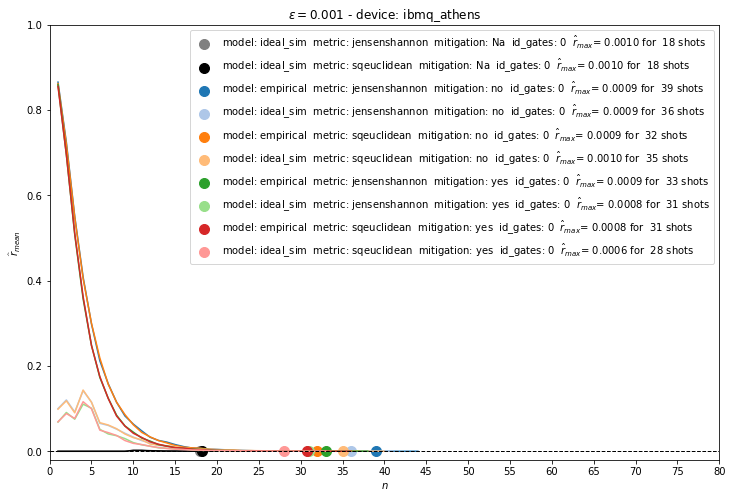

In [43]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors are the unsmoothed values 
opl.plot_curves(ideal_data_list + empirical_data_list,
                np.array(range(2+len(empirical_data_list))),
            "$\epsilon=0.001$" , ["device"],
            ["model","metric","mitigation","id_gates"],
            right_xlimit = 80, bottom_ylimit = -0.02, top_ylimit = 1)

## New optimizer

In [44]:
# here will be appended the data we want for the final plot of this notebook
empirical_data_list=[]

# the following values are defined in the study summary notebook:
trials=1000 # should be 1000 if not demo
window=11
epsilon = .001
max_shots = 500
pol=2

verbosality = 10 # printing step for intermediate results when increasing the experiment shot number 

# In this section you can easily make your choice of combinations:
# mitigation or not, metric, model 

mitigation_dic =  {"no":False, "yes" : True} 
#mitigation_dic =  {"no":False} 
#mitigation_dic =  {"yes" : True} 

o_metrics_desired = ['jensenshannon', 'sqeuclidean']
#o_metrics_desired = ['jensenshannon']
#o_metrics_desired = ['sqeuclidean']

model_dic = {"empirical": PD_exper, "ideal_sim": PD_ideal}
#model_dic = {"empirical": PD_exper}
#model_dic = {"ideal_sim": PD_ideal}

# Obtain a sequence of results in form of a list of dictionaries

for mit_str, mitigation in mitigation_dic.items():
    # here we toggle PD_exper as we toggled mitigation status
    PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    for o_metric in o_metrics_desired:
        print(project_name, model_dic.keys(), o_metric)        
        for model_name in model_dic.keys():
            add_single_dic(empirical_data_list, optimizer_type='new')

AL2_Ath_M000 dict_keys(['empirical', 'ideal_sim']) jensenshannon
started 30/05/2021 21:37:17 AL2_Ath mitigation no jensenshannon empirical
safe_shot_nb 31 safe_rate 0.001 nb trials: 1000
savgol interpolated error rate mean: -0.0041 min: -0.0128 max: -0.0004 for [11]
completed 30/05/2021 21:39:07 AL2_Ath mitigation no jensenshannon empirical 

started 30/05/2021 21:39:07 AL2_Ath mitigation no jensenshannon ideal_sim
safe_shot_nb 34 safe_rate 0.0 nb trials: 1000
savgol interpolated error rate mean: -0.002 min: -0.0055 max: -0.0002 for [19]
completed 30/05/2021 21:41:03 AL2_Ath mitigation no jensenshannon ideal_sim 

AL2_Ath_M000 dict_keys(['empirical', 'ideal_sim']) sqeuclidean
started 30/05/2021 21:41:03 AL2_Ath mitigation no sqeuclidean empirical
safe_shot_nb 39 safe_rate 0.001 nb trials: 1000
savgol interpolated error rate mean: 0.0 min: 0.0 max: 0.0 for [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
completed 30/05/2021 21:42:39 AL2_Ath mitigation no sqeuclide

<Figure size 432x288 with 0 Axes>

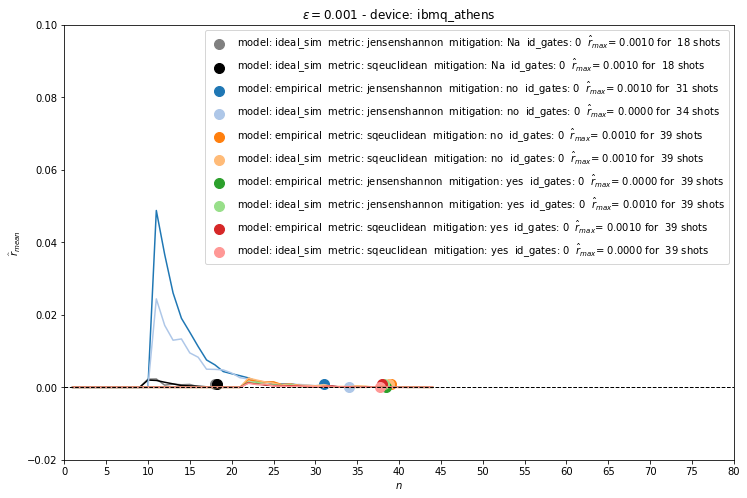

In [47]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors are the unsmoothed values 
opl.plot_curves(ideal_data_list + empirical_data_list,
                np.array(range(2+len(empirical_data_list))),
            "$\epsilon=0.001$" , ["device"],
            ["model","metric","mitigation","id_gates"],
            right_xlimit = 80, bottom_ylimit = -0.02, top_ylimit = 0.1)